<a href="https://colab.research.google.com/github/ghgh415263/Mal_dectection/blob/main/model_VGG16_TL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.applications.vgg16 import VGG16

import pathlib

DATA_PATH = "/content/dataset"
batch_size = 32
img_height = 224
img_width = 224

data_dir = pathlib.Path(DATA_PATH)  #bicubic bilinear

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  color_mode='rgb',
  interpolation='bilinear',
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  color_mode='rgb',
  interpolation='bilinear',
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


base_model = VGG16(weights="imagenet", include_top=False, input_shape=(img_height,img_width,3))
base_model.trainable=False

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    base_model,
    layers.Flatten(),
    layers.Dense(25, activation='softmax')
])

model.summary()

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=2340,
    decay_rate=0.2,
    staircase=False) #staircase=False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

checkpoint_path = "/content/drive/MyDrive/Colab_Notebooks/save/training-vgg16-1layer-bicubic2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

#latest = tf.train.latest_checkpoint("/content/drive/MyDrive/Colab_Notebooks/malware_model192x192/save/training-res50-1layer")
#model.load_weights(latest)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    period=200)

history = model.fit(train_ds, epochs=40, validation_data=val_ds, callbacks=[cp_callback])

Found 9339 files belonging to 25 classes.
Using 7472 files for training.
Found 9339 files belonging to 25 classes.
Using 1867 files for validation.
58900480/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 25)                627225    
                                                                 
Total params: 15,341,913
Trainable params: 627,225
Non-trainable params: 14,714,688
_______________________

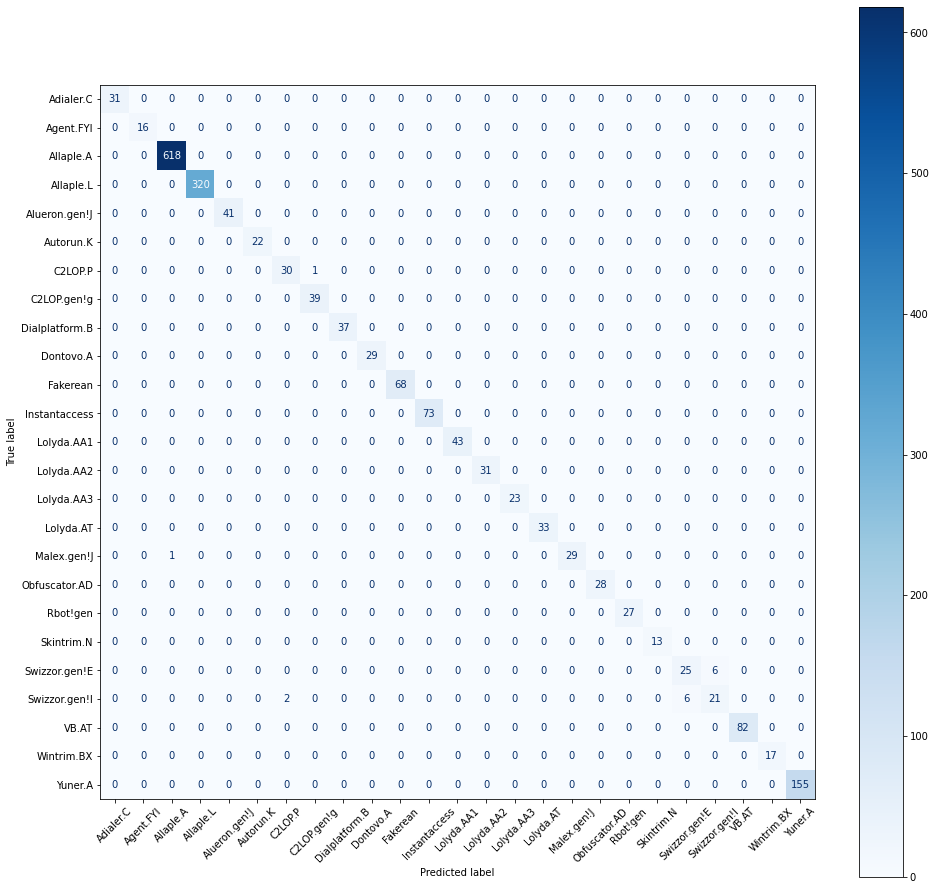

In [7]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

y_test = np.array([])
y_pred = np.array([])

for x,y in val_ds:
  y_test = np.append(y_test, y.numpy(), axis=0)
  tmp = (model.predict(x)).argmax(axis=-1)
  y_pred = np.append(y_pred, tmp, axis=0)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_ds.class_names)
fig, ax = plt.subplots(figsize=(16,16))

disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45)
plt.show()

In [ ]:
rm -r "/content/drive/MyDrive/Colab_Notebooks/save/training-vgg16-1layer-bilinear,bicubic"

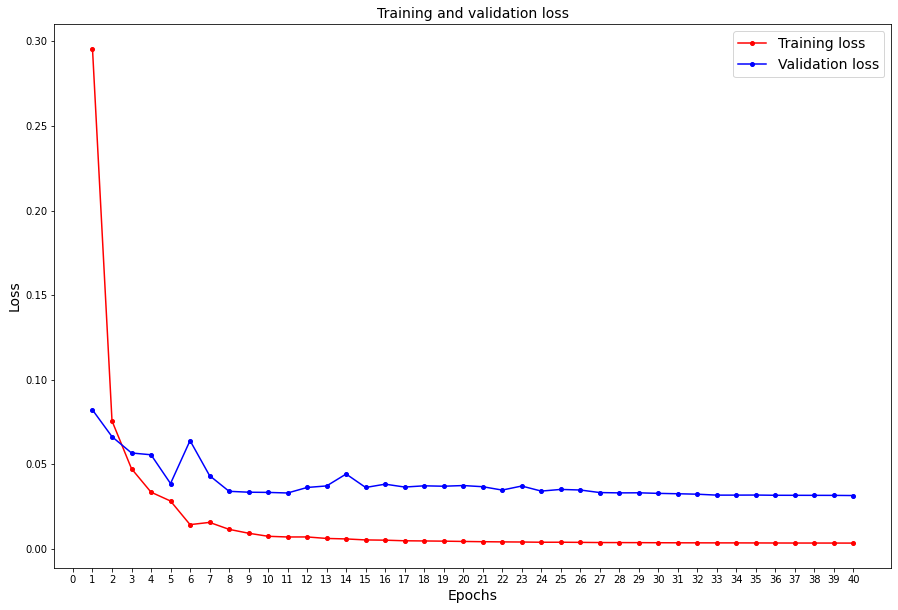

In [8]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15,10))
plt.plot(epochs, loss, 'ro-', label='Training loss', markersize = 4)
plt.plot(epochs, val_loss, 'bo-', label='Validation loss', markersize = 4)
plt.title('Training and validation loss', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=14)
plt.xticks(range(len(acc) + 1), range(len(acc) + 1))

plt.show()

<Figure size 432x288 with 0 Axes>

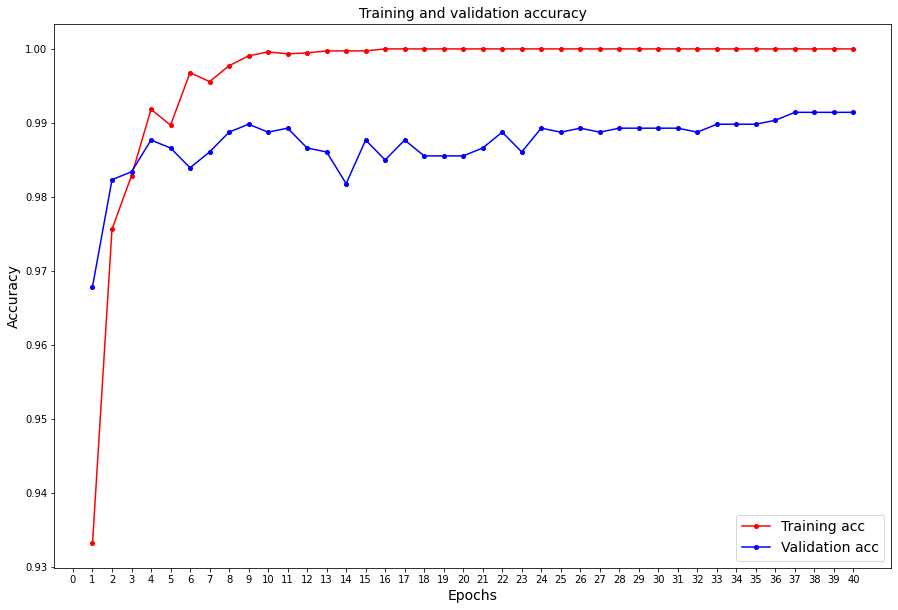

In [9]:
plt.clf()   # 그림을 초기화합니다

plt.figure(figsize=(15,10))
plt.plot(epochs, acc, 'ro-', label='Training acc', markersize = 4)
plt.plot(epochs, val_acc, 'bo-', label='Validation acc', markersize = 4)
plt.title('Training and validation accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=14)
plt.xticks(range(len(acc) + 1), range(len(acc) + 1))

plt.show()

In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/data/malimg_dataset.zip" -d "/content/dataset"

In [10]:
print("%-8s" % "epoch", "%-23s" % "train_loss", "%-23s" % "val_loss", "%-23s" % "train_acc", "%-23s" % "val_acc")
print("=" * 99)
for i in range(1,len(acc)+1):
        print("%-8s" %i, "%-23s" % loss[i-1], "%-23s" % val_loss[i-1], "%-23s" % acc[i-1], "%-23s" % val_acc[i-1])

epoch    train_loss              val_loss                train_acc               val_acc                
1        0.29552149772644043     0.08222643285989761     0.9332173466682434      0.9678629040718079     
2        0.07574398070573807     0.06641638278961182     0.9756423830986023      0.9823246002197266     
3        0.04749637097120285     0.05678783357143402     0.9828693866729736      0.9833958148956299     
4        0.033637214452028275    0.05572948232293129     0.9918361902236938      0.9876807928085327     
5        0.028407078236341476    0.03873280808329582     0.9896948337554932      0.9866095185279846     
6        0.014461198821663857    0.06410770863294601     0.9967880249023438      0.9839314222335815     
7        0.01577661745250225     0.04341275990009308     0.9955835342407227      0.986073911190033      
8        0.011672346852719784    0.03414851799607277     0.9977248311042786      0.988752007484436      
9        0.009376045316457748    0.03361094370484352   